In [35]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style='whitegrid', palette='muted')
np.random.seed(1)
tf.random.set_seed(1)

# print('Tensorflow version:', tf.__version__)

In [2]:
!pip install gdown

In [3]:
!gdown --id 1ydIDd4tq-vUaQDp7WU0DsRP4uiwdj9ko --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=1ydIDd4tq-vUaQDp7WU0DsRP4uiwdj9ko
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 55.7MB/s]


Data in here https://www.kaggle.com/pdquant/sp500-daily-19862018  S&P500 Daily Prices 1986 - 2018

In [36]:
df = pd.read_csv('spx.csv', parse_dates=['date'])
print('shape', df.shape)
df.head()

shape (8192, 2)


,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


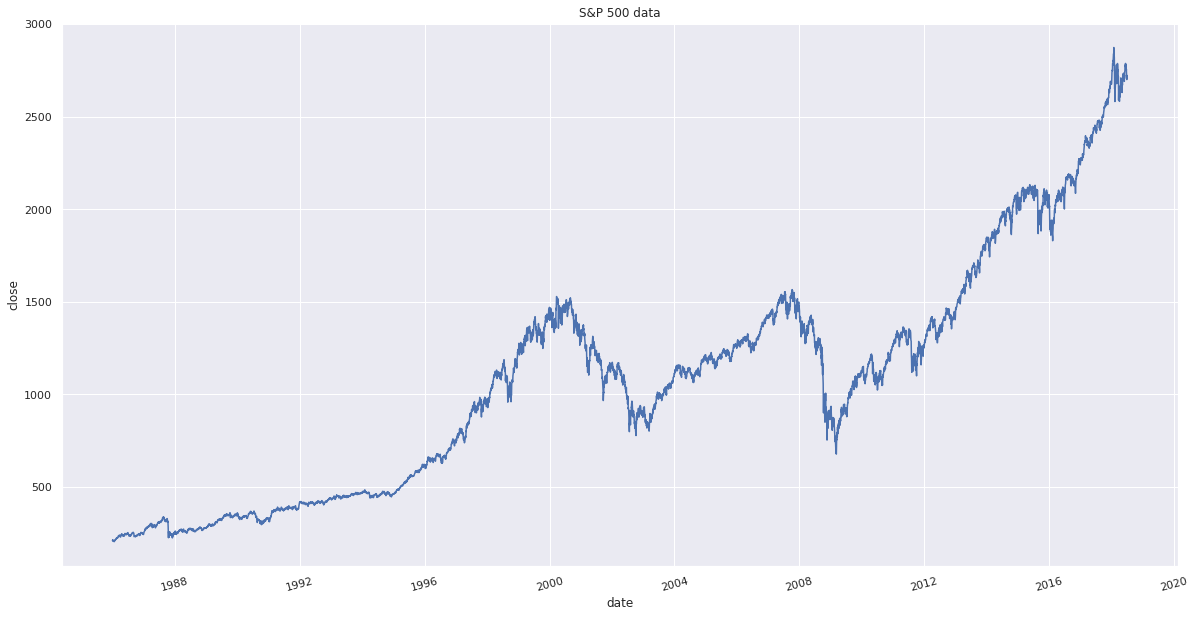

In [37]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x=df['date'], y=df['close'], data=df)
plt.xticks(rotation=15)
plt.title('S&P 500 data')
plt.show()

In [38]:
train_size = int(len(df)*0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 2) (410, 2)


## Data Preprocessing

In [40]:
# pd.options.mode.chained_assignment = None

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler = scaler.fit(train[['close']])

# train['close'] = scaler.transform(train[['close']])
# test['close'] = scaler.transform(test[['close']])
print(max(train['close']),min(train['close']))
print(type(train[['close']]))
type(train.close)

2.2449382714224595 -1.4865839645077903
<class 'pandas.core.frame.DataFrame'>


pandas.core.series.Series

## Create Training and Test Splits

In [9]:
def create_sequences(X, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        Ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

In [10]:
time_steps=30
X_train, y_train = create_sequences(train[['close']], time_steps)
X_test, y_test = create_sequences(test[['close']], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_train)
print(y_test)

(7752, 30, 1) (7752, 1)
(380, 30, 1) (380, 1)
[[-1.46045696]
 [-1.4560242 ]
 [-1.4509716 ]
 ...
 [ 2.14991562]
 [ 2.19443107]
 [ 2.20235745]]
[[2.39281599]
 [2.35720362]
 [2.35596395]
 [2.33637339]
 [2.37206089]
 [2.39632839]
 [2.39304138]
 [2.40803013]
 [2.39285355]
 [2.39285355]
 [2.40491217]
 [2.39574612]
 [2.40363494]
 [2.39095648]
 [2.39846964]
 [2.38306767]
 [2.39738023]
 [2.38590388]
 [2.41383405]
 [2.44820674]
 [2.44503243]
 [2.44129464]
 [2.41539303]
 [2.4115801 ]
 [2.41285734]
 [2.41529911]
 [2.44642237]
 [2.43729388]
 [2.43827059]
 [2.44125707]
 [2.46605049]
 [2.48150881]
 [2.50433002]
 [2.52185446]
 [2.5437741 ]
 [2.53996117]
 [2.54736163]
 [2.57407091]
 [2.56926249]
 [2.57112199]
 [2.57775235]
 [2.58227903]
 [2.57080268]
 [2.63150899]
 [2.60513781]
 [2.60739176]
 [2.59272232]
 [2.57972456]
 [2.56956301]
 [2.57311298]
 [2.58763216]
 [2.58926627]
 [2.57420239]
 [2.6114113 ]
 [2.60412354]
 [2.59824449]
 [2.58926627]
 [2.53395065]
 [2.54227147]
 [2.53759453]
 [2.53387552]
 [2.

## Build LSTM autoencoder

In [11]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]
print(time_steps)
print(num_features)

30
1


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps), # replicates features from outputs (30 times)
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    # Time distributed layer to get an output with right shape
    TimeDistributed(Dense(num_features))
])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 15s 69ms/step - loss: 0.1456 - val_loss: 0.2471
Epoch 2/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0673 - val_loss: 0.1801
Epoch 3/10
218/218 [==============================] - 14s 66ms/step - loss: 0.0831 - val_loss: 0.1688
Epoch 4/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0515 - val_loss: 0.1281
Epoch 5/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0499 - val_loss: 0.0673
Epoch 6/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0593 - val_loss: 0.0558
Epoch 7/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0597 - val_loss: 0.0554
Epoch 8/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0639 - val_loss: 0.0617
Epoch 9/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0655 - val_loss: 0.0479
Epoch 10/10
218/218 [==============================] - 14s 65ms/step - loss: 0.064

In [15]:
history.history

{'loss': [0.14559289813041687,
  0.06732196360826492,
  0.08306457102298737,
  0.05148511007428169,
  0.04986103996634483,
  0.059286314994096756,
  0.0596667043864727,
  0.06388838589191437,
  0.06554138660430908,
  0.0644170418381691],
 'val_loss': [0.2470574527978897,
  0.18006692826747894,
  0.1688077300786972,
  0.12813986837863922,
  0.06732695549726486,
  0.055765002965927124,
  0.05535484105348587,
  0.06172068044543266,
  0.04794777184724808,
  0.08833514899015427]}

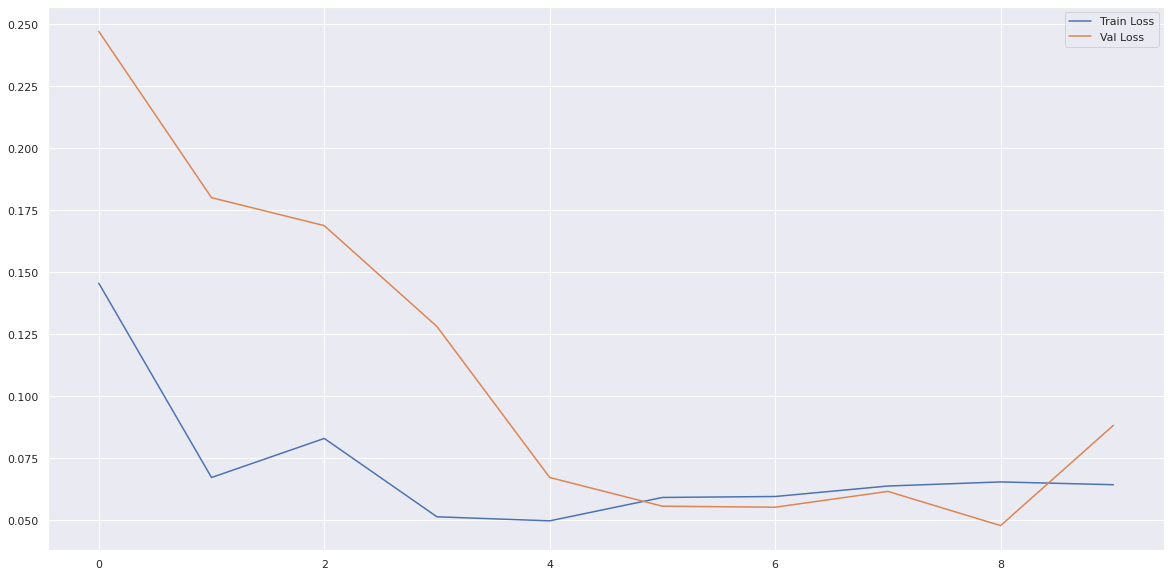

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()


In [17]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [18]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 20ms/step - loss: 0.2527


0.25267982482910156

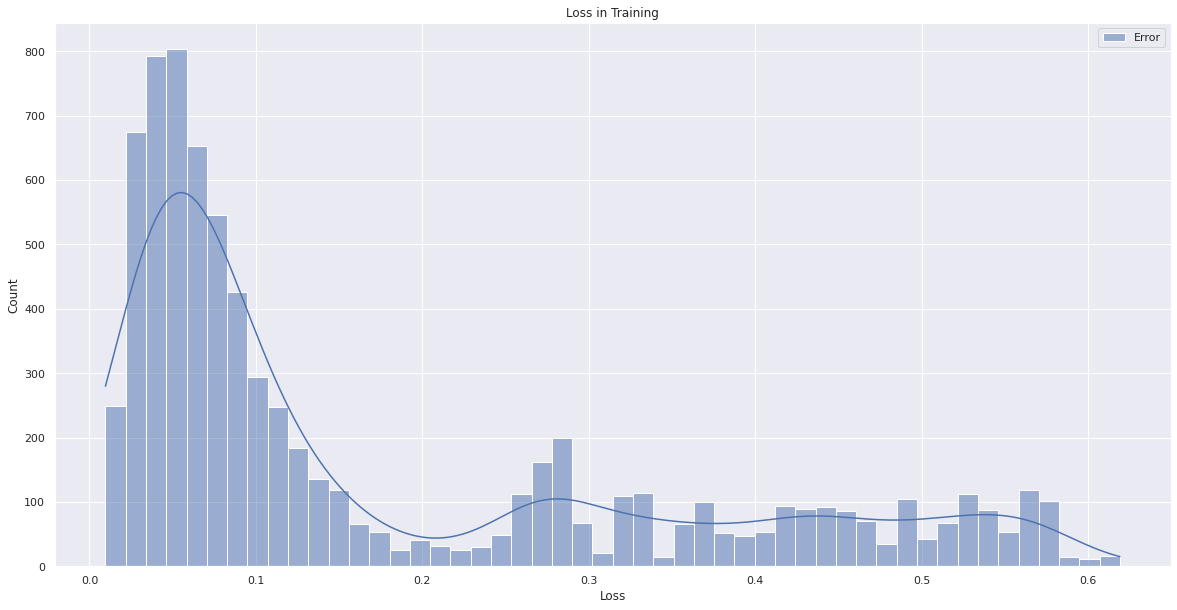

In [19]:
# sns.distplot(train_mae_loss, bins=50, kde=True)
# sns.displot(train_mae_loss, bins=50, kde=True)
sns.set(rc={'figure.figsize':(20,10)})
# sns.lineplot(x=df['date'], y=df['close'], data=df)
# plt.xticks(rotation=15)
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.title('Loss in Training')
plt.xlabel('Loss')
# plt.ylabel('Inde')
plt.show()

In [20]:
threshold = .34

In [21]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [22]:
# values classified as anomalies are the ones that exceed the threshold
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [23]:
test_score_df.head()

,date,close,loss,threshold,anomaly
7812,2016-12-27,2.392816,0.117543,0.34,False
7813,2016-12-28,2.357204,0.115322,0.34,False
7814,2016-12-29,2.355964,0.130140,0.34,False
7815,2016-12-30,2.336373,0.137187,0.34,False
7816,2017-01-03,2.372061,0.149465,0.34,False


In [24]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,3.234646,0.318189,0.34,False
8188,2018-06-26,3.245897,0.348382,0.34,True
8189,2018-06-27,3.201889,0.357558,0.34,True
8190,2018-06-28,3.233219,0.377150,0.34,True
8191,2018-06-29,3.237088,0.373100,0.34,True


In [27]:
# data_test_loss = np.array([test[time_steps:].date, test_score_df.loss])
# data_test_loss = data_test_loss.T
# indexes = range(0, data_test_loss.shape[0])
# data_test_loss = pd.DataFrame(data_test_loss,  columns=["A", "B"])
# data_test_loss["B"] = pd.to_numeric(data_test_loss["B"])
# data_test_loss.dtypes

# sns.set(rc={'figure.figsize':(20,10)})
# sns.lineplot(x=data_test_loss['A'], y=data_test_loss['B'], data=data_test_loss)
# plt.xticks(rotation=15)
# plt.title('S&P 500 data')
# plt.show()

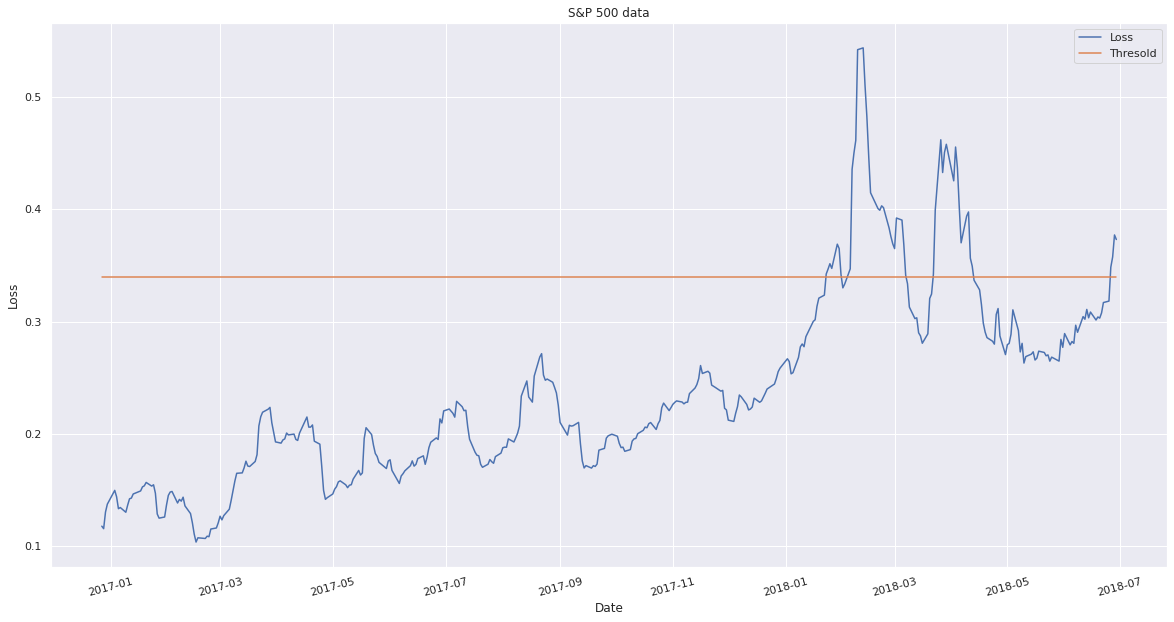

In [25]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x=test_score_df['date'], y=test_score_df['loss'], data=test_score_df)
sns.lineplot(x=test_score_df['date'], y=test_score_df['threshold'], data=test_score_df)
plt.xticks(rotation=15)
plt.title('S&P 500 data')
plt.xlabel('Date')
plt.ylabel('Loss')
plt.legend(labels=['Loss', 'Thresold'])
plt.show()

In [26]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
8081,2018-01-23,3.463910,0.342324,0.34,True
8082,2018-01-24,3.460924,0.346742,0.34,True
8083,2018-01-25,3.464136,0.351516,0.34,True
8084,2018-01-26,3.527284,0.347341,0.34,True
8085,2018-01-29,3.490958,0.368932,0.34,True


In [28]:

# anomalies['anomaly'].dtypes
# anomalies['loss'].min 
#   print("its there")
# else:
#   print('not there')

In [29]:
X_data, Y_data = test[:].date, scaler.inverse_transform(test[:].close)
print(len(X_data), len(Y_data))


410 410


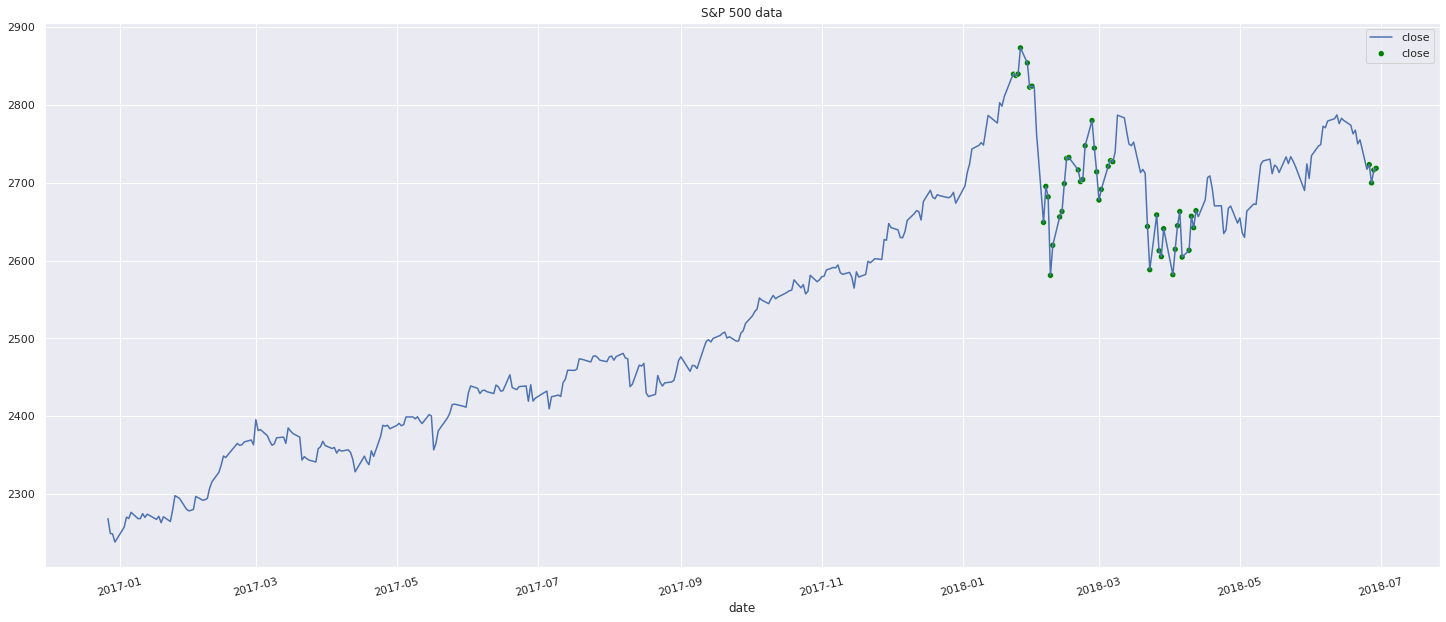

30

In [30]:
# time_steps = 30*30
sns.set(rc={'figure.figsize':(25,10)})

X_data, Y_data = test[:].date, scaler.inverse_transform(test[:].close)
X_anomaly, Y_anomaly = anomalies.date, scaler.inverse_transform(anomalies.close)
sns.scatterplot(x=X_anomaly, y=Y_anomaly, markers=True, hue="anomaly", palette=['green'] , data=anomalies)

sns.lineplot(x=X_data[time_steps: ], y=Y_data[time_steps:], data=test[time_steps:])
plt.xticks(rotation=15)
plt.title('S&P 500 data')
plt.legend(labels=['close', 'close'])
plt.show()
time_steps